In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization

Could not find GLIMDA.


Current package version of pyfoomb: 2.17.0


# Implementing an ODE model with observation functions

According to widely-adopted nomenclature, the general formulation reads:

$$
\begin{align}
    \frac{d\mathbf{x}\left(\mathbf{\theta_x}, t\right)}{dt} &= \mathbf{f}\left(\mathbf{x}\left(\mathbf{\theta_x}, t\right), \mathbf{\theta_x}, t\right), & \mathbf{x}\left(\mathbf{\theta_x}, t_0\right) = \mathbf{x}_0 \left(\mathbf{\theta_x}\right)\\
    \mathbf{y}\left(\mathbf{\theta_y}, t\right) &= \mathbf{g}\left(\mathbf{x}\left(\mathbf{\theta_x}, t\right), t, \mathbf{\theta_y}\right)\\
    \mathbf{\theta} &= \left[\mathbf{\theta_x}^T, \mathbf{x}_0^T, \mathbf{\theta_y}^T \right]^T\\
\end{align}
$$


## Application example: Batch growth with growth-coupled product formation

The model describes a simple batch growth, with the growth rate model by the famous Monod equation with one limiting substrate. Product formation is formulated as Luedeking-Piret model, lacking a non-growth associated term.

The 3 model states are observed by 3 different methods:

Optical density `OD600` observes the biomass concentration `X`. Product concentration `P` is observed by `AreaHPLC` measurements using a linear calibration. A biosensor `FretRatio`, that has a saturation-like calibration function, is used for observing the substrate concentration `S`. 


## The model $\mathbf{f\left(\cdot\right)}$

### Specific rates
$$
\begin{align}
    \mu &= \mu_{max} \cdot \frac{c_S}{k_S + c_S}\\
    q_S &= -\frac{1}{Y_{X/S}} \cdot \mu \\
    q_P &= Y_{P/X} \cdot \mu
\end{align}
$$

### State derivatives
$$
\begin{align}
    \frac{dc_X}{dt} &= \mu \cdot c_X & c_X \left(t_0\right) = c_{X,0}\\
    \frac{dc_S}{dt} &= q_S \cdot c_X & c_S \left(t_0\right) = c_{S,0}\\
    \frac{dc_P}{dt} &= q_P \cdot c_X & c_P \left(t_0\right) = c_{P,0}\\
\end{align}
$$

### Model parametrization
$$
\begin{align}
    \mathbf{\theta_x} &= \left[k_S \; \mu_{max} \; Y_{P/X} \; Y_{X/S}\right]^T\\
    \mathbf{x}_0 &= \left[c_{P,0} \; c_{S,0} \; c_{X,0}\right]^T
\end{align}
$$

In [2]:
# Defines the model class
class BatchProcess(BioprocessModel):
    
    def rhs(self, t, y):
        
        # unpacking the state vector in alphabetical order, corresponding to the order of initial values
        P, S, X = y
        
        # unpacking the model parameters, can also be done via the corresponding keys which is more explict
        k_S, mu_max, Y_PX, Y_XS = self.model_parameters.to_numpy()
            
        # model equations
        mu = mu_max * S / (k_S + S)
        q_P = Y_PX * mu
        q_S = -1/Y_XS * mu
        
        # state derivatives
        dPdt = q_P * X
        dSdt = q_S * X
        dXdt = mu * X
        
        return [dPdt, dSdt, dXdt]
    
# Defines a dictionary for the initial values.
# The keys corresponds to the model states, extended by a 0 (zero).
initial_values = {
    'X0' : 0.01,
    'P0' : 0.0,
    'S0' : 20.0,
}

# Defines a dictionary for the model parameters
# The keys match those variable names used in the model class
model_parameters = {
    'k_S' : 0.01,
    'mu_max' : 0.4,
    'Y_PX' : 0.4,
    'Y_XS' : 0.5,
}

### Observation function $\mathbf{g}\left(\cdot\right)$
$$
\begin{align}
    OD_{600} &= c_X \cdot m_{OD_{600}}\\
    FretRatio &= \frac{\left(r_{sat} - r_0 \right) \cdot c_S}{k_D + c_S} + r_0 \\
    AreaHPLC &= c_P \cdot m_{HPLC} + b_{HPLC}\\
\end{align}
$$

### Observation function parametrization
$$
\begin{align}
    \mathbf{\theta_y} &= \left[m_{OD_{600}} \; m_{HPLC} \; b_{HPLC} \; r_0 \; r_{sat} \; k_D \; \right]^T\\
\end{align}
$$

### Overall parametrization

The overall parametrization describes all parameters that define the model. The corresponding parameter vector $\mathbf{\theta}$ holds the model parameters, initial values, and the observation parameters.

$$
\begin{align}
    \mathbf{\theta} &= \left[ \mathbf{\theta_x}^T \; \mathbf{x}_0^T \;\mathbf{\theta_y}^T\right]^T = \left[k_S \; \mu_{max} \; Y_{P/X} \; Y_{X/S} \; c_{P,0} \; c_{S,0} \; c_{X,0} \; m_{OD_{600}} \; m_{HPLC} \; b_{HPLC} \; r_0 \; r_{sat} \; k_D \; \right]^T\\
\end{align}
$$

In [3]:
# Defines a observation function class, that inherits from `ObservationFunction`.
# It must implement the method `observe`, taking model values as input, returning the corresponding observation.
# For OD600, a linear calibration is used, lacking an offset.
class OD600(ObservationFunction):

    def observe(self, model_values):
        # parameter unpacking
        m_od600 = self.observation_parameters['m_od600']
        return model_values * m_od600
    
# Defines a dictionary containing the parameters for the observation function.
# Also, the observed model state must be declared, which must be in accordance to the observed model.
observation_parameters_od600 = {
    'observed_state' : 'X',
    'm_od600' : 2.0,
}

In [4]:
# Defines the observation function `AreaHPLC` and its parameter dictionary, observing the model state `P`.
class HPLC(ObservationFunction):
    
    def observe(self, model_values):
        # parameter unpacking
        m_hplc = self.observation_parameters['m_hplc']
        b_hplc = self.observation_parameters['b_hplc']
        return model_values * m_hplc + b_hplc    

observation_parameters_hplc = {
    'observed_state' : 'P',
    'm_hplc' : 2450.0, 
    'b_hplc' : 1100.0,
}

In [5]:
# Defines the observation function `FretRatio` and its parameter dictionary, observing the model state `S`.
class FretRatio(ObservationFunction):

    def observe(self, model_values):
        # parameter unpacking
        r0 = self.observation_parameters['r0']
        r_sat = self.observation_parameters['r_sat']
        k_D = self.observation_parameters['k_D']
        return (((r_sat - r0) * model_values) / (k_D + model_values)) + r0    
    
observation_parameters_fret_ratio = {
    'observed_state' : 'S',
    'r0' : 0.9,
    'r_sat' : 1.45,
    'k_D' : 1.6,
}

In [6]:
# Creates a list, containing the tuples of ObservationFunction subclasses and their parameter dictionaries
observations_functions = [
    (OD600, observation_parameters_od600),
    (HPLC, observation_parameters_hplc),
    (FretRatio, observation_parameters_fret_ratio),
]

In [7]:
# Instantiate a Caretaker, which manages the model, its parametrization, the observation functions their parametrizations,
# as well as the replicate `1st`.
caretaker = Caretaker(
    bioprocess_model_class=BatchProcess, 
    model_parameters=model_parameters,
    initial_values=initial_values,
    observation_functions_parameters=observations_functions,
    replicate_ids=['1st'],
)

In [8]:
# Out of curiosity, have a look at the current parameter mapping
caretaker.parameter_mapping

,,local_name,value
global_name,replicate_id,,
b_hplc,1st,b_hplc,1100
k_D,1st,k_D,1.6
k_S,1st,k_S,0.01
m_hplc,1st,m_hplc,2450
m_od600,1st,m_od600,2
mu_max,1st,mu_max,0.4
P0,1st,P0,0
r0,1st,r0,0.9
r_sat,1st,r_sat,1.45


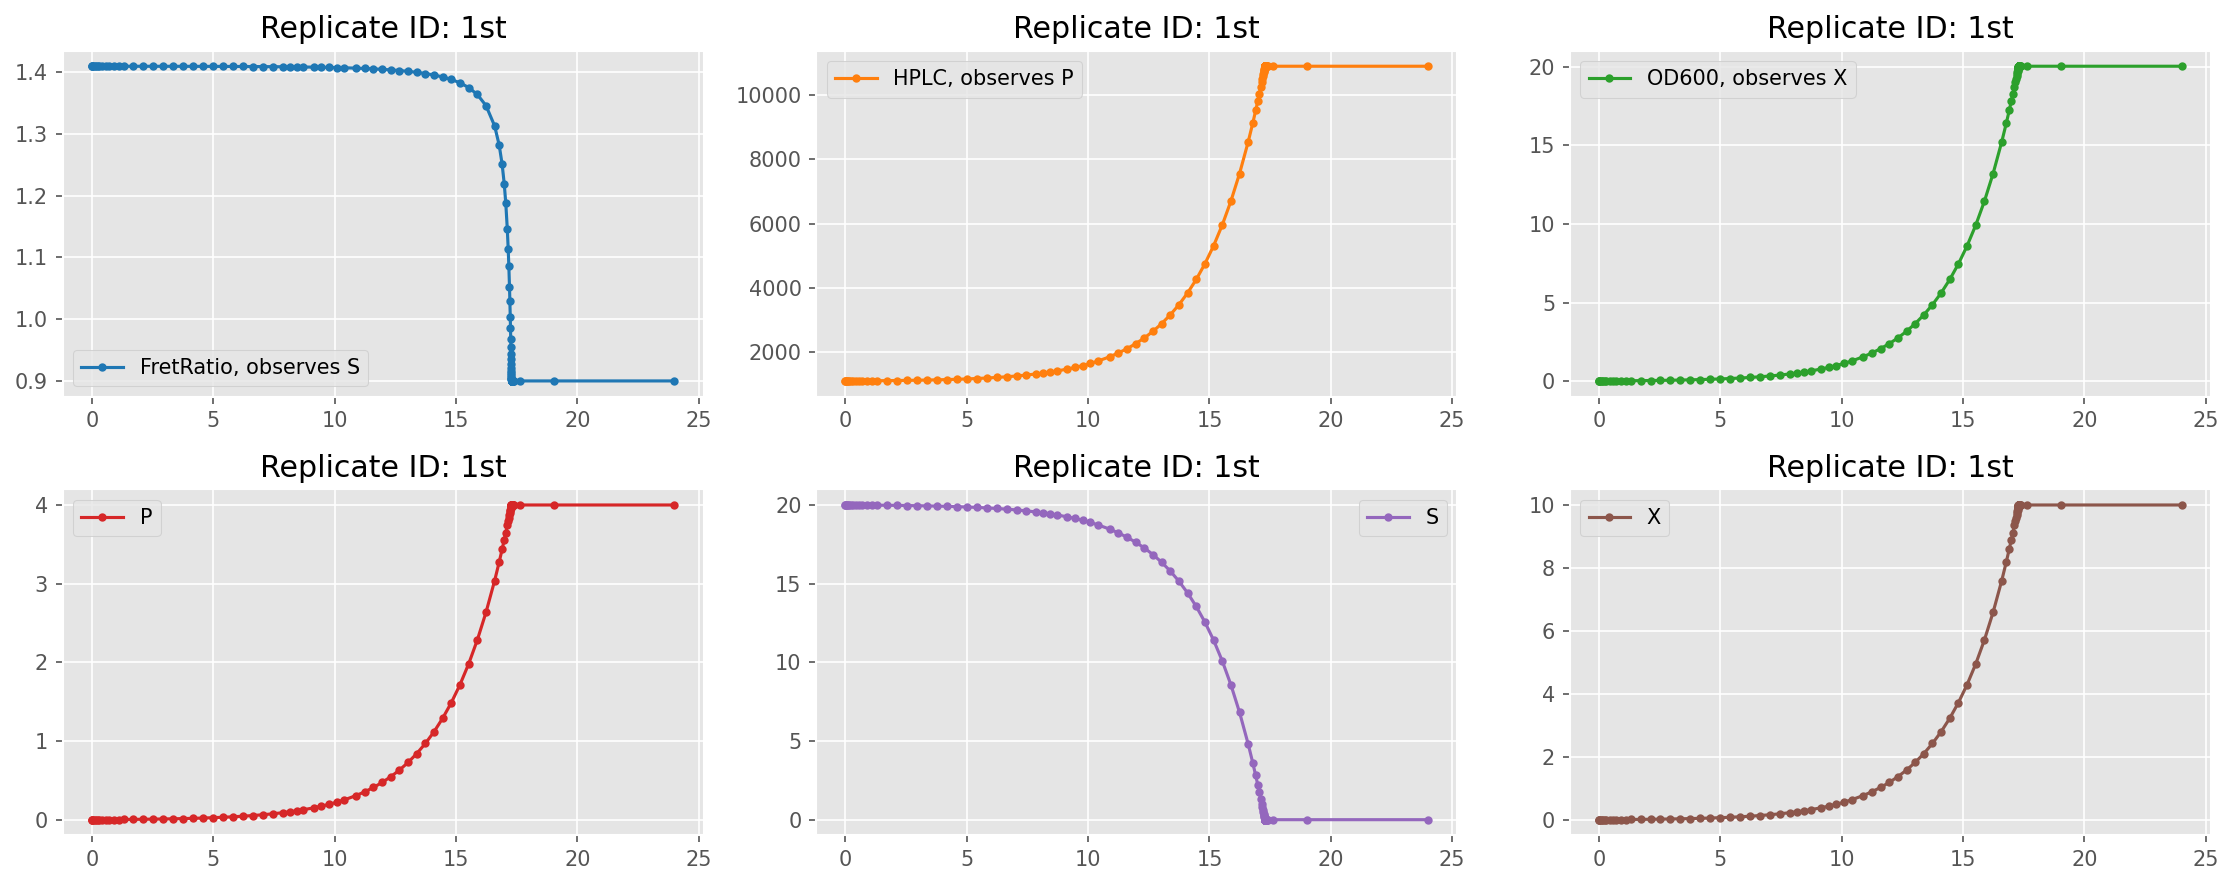

In [9]:
# Runs a forward simulation.
simulation = caretaker.simulate(t=24)

# Visualize the resulting trajectories
_ = Visualization.show_kinetic_data(simulation)

Now, consider that the model state `X` (the biomass concentration), can also be observed by another method, e.g. cell counts `CC`. As a feature of `pyFOOMB`, the model states can be observed by multiple ObservationFunctions. 

From a practical point of view, this is useful for cases where methods may cover different ranges of the observed model states, or if different experiments (i.e., replicates) describe the same underlying model, but some states have been observed by different methods. These aspects come mainly into play for model calibation / parameter estimation from experimental data.

Let's implement the corresponding `CC` class and parameter dictionary.

### Updated observation function $\mathbf{g\left(\cdot\right)}$
$$
\begin{align}
    OD_{600} &= c_X \cdot m_{OD_{600}}\\
    FretRatio &= \frac{\left(r_{sat} - r_0 \right) \cdot c_S}{k_D + c_S} + r_0 \\
    AreaHPLC &= c_P \cdot m_{HPLC} + b_{HPLC}\\
    CC &= c_X \cdot m_{CC} + b_{CC}\\
\end{align}
$$

### Updated observation function parametrization
$$
\begin{align}
    \mathbf{\theta_y} &= \left[m_{OD_{600}} \; m_{HPLC} \; b_{HPLC} \; r_0 \; r_{sat} \; k_D \; m_{CC} \; b_{CC}\right]^T\\
\end{align}
$$

### Updated overall parametrization
$$
\begin{align}
    \mathbf{\theta} &= \left[ \mathbf{\theta_x}^T \; \mathbf{x}_0^T \;\mathbf{\theta_y}^T\right]^T = \left[k_S \; \mu_{max} \; Y_{P/X} \; Y_{X/S} \; c_{P,0} \; c_{S,0} \; c_{X,0} \; m_{OD_{600}} \; m_{HPLC} \; b_{HPLC} \; r_0 \; r_{sat} \; k_D \; m_{CC} \; b_{CC}\right]^T\\
\end{align}
$$

In [10]:
# Defines the observation function `CC` and its parameter dictionary, also observing the model state `X`.
class CC(ObservationFunction):

    def observe(self, model_values):
        # parameter unpacking
        m_cc = self.observation_parameters['m_cc']
        b_cc = self.observation_parameters['b_cc']
        return model_values * m_cc + b_cc
    
observation_parameters_cc = {
    'observed_state' : 'X',
    'm_cc' : 1e6,
    'b_cc' : 10,
}

In [11]:
# Re-creates the caretaker (overwrite the old one), but this time with a new observation function
observations_functions = [
    (OD600, observation_parameters_od600),
    (HPLC, observation_parameters_hplc),
    (FretRatio, observation_parameters_fret_ratio),
    (CC, observation_parameters_cc)
]

caretaker = Caretaker(
    bioprocess_model_class=BatchProcess, 
    model_parameters=model_parameters,
    initial_values=initial_values,
    observation_functions_parameters=observations_functions,
    replicate_ids=['1st'],
)

In [12]:
# Out of curiosity, have a look at the current parameter mapping
caretaker.parameter_mapping

,,local_name,value
global_name,replicate_id,,
b_cc,1st,b_cc,10
b_hplc,1st,b_hplc,1100
k_D,1st,k_D,1.6
k_S,1st,k_S,0.01
m_cc,1st,m_cc,1e+06
m_hplc,1st,m_hplc,2450
m_od600,1st,m_od600,2
mu_max,1st,mu_max,0.4
P0,1st,P0,0


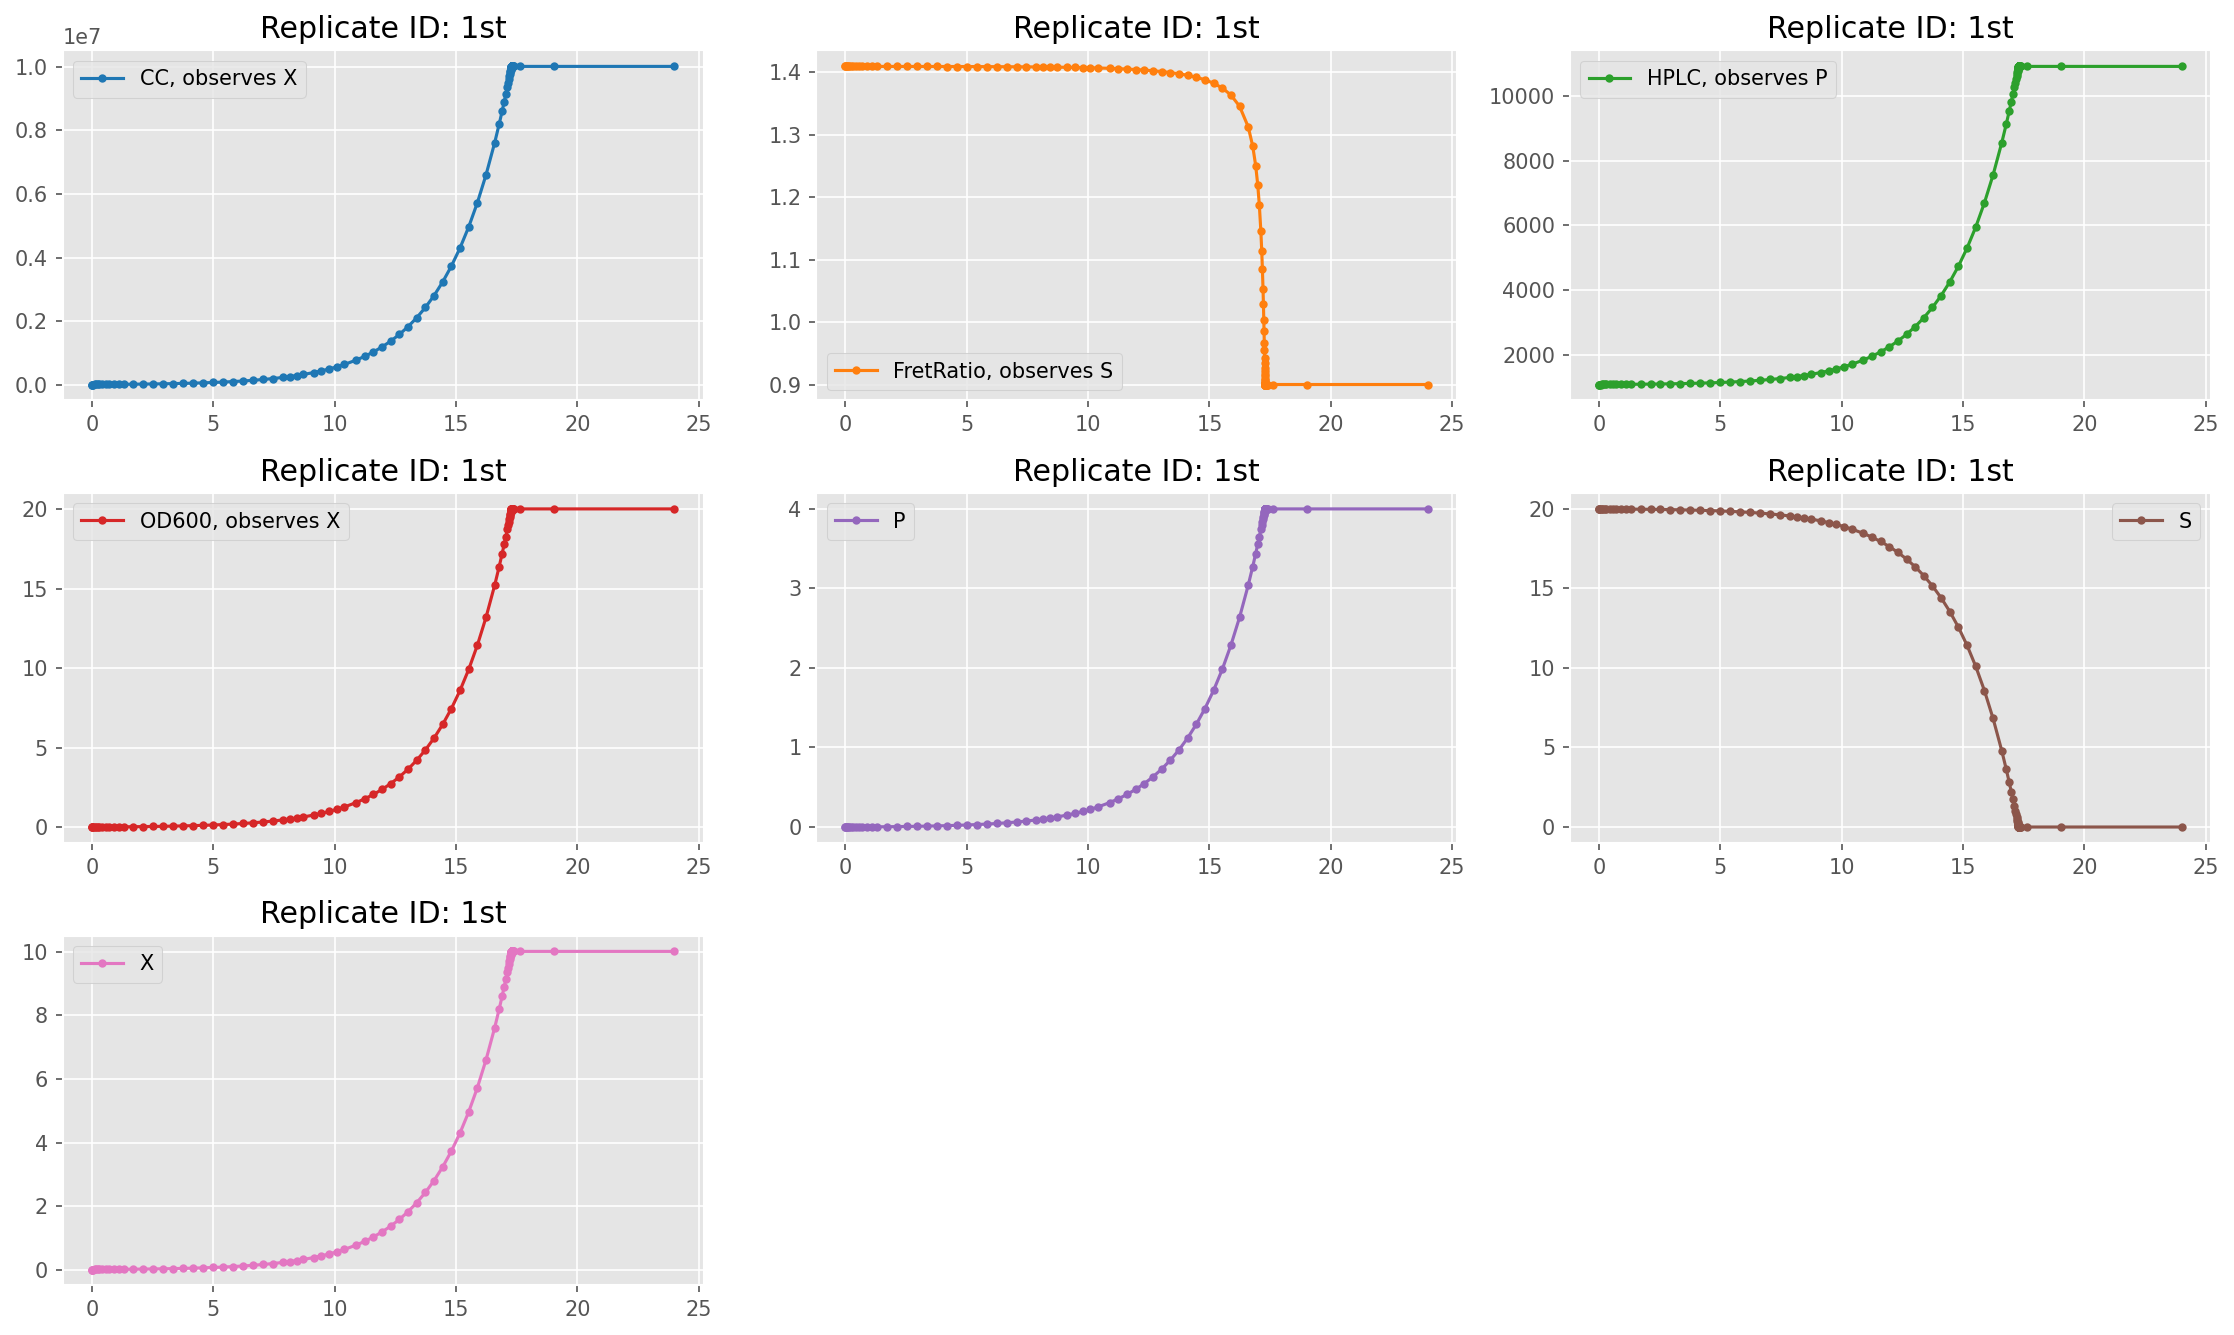

In [13]:
# Runs a forward simulation.
simulation = caretaker.simulate(t=24)

# Visualize the resulting trajectories
_ = Visualization.show_kinetic_data(simulation)